## Engagement Analyse

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import gzip
# import torch
import re
from pathlib import Path
import json
import numpy as np
from datetime import datetime, timezone, timedelta
from dateutil.relativedelta import relativedelta
import os
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

In [3]:
print(os.getcwd())

C:\Users\annab\Documents\GitHub\radical\analyse_fase-kenmerken_onderzoek\Engagement


# Twee verschillende datasets
Er zijn twee verschillende datasets gemaakt, met behulp van dezelfde scraper. Het verschil in gebruik van de scrapers ligt in de limieten die zijn gesteld. Bij de eerste dataset zijn er batches van 25 gebruikt met een limiet van 300 rondes per batch. Bij de tweede is er een limiet van 500 rondes gesteld.

In [9]:
path_1 = Path(r"..\..\aqcuisition_fase-scrapers\Bluesky\Data\bs-posts.jsonl.gz")
path_2 = Path(r"..\..\aqcuisition_fase-scrapers\Bluesky\Data\bs-posts_2.jsonl.gz")

In [10]:
if os.path.isfile(path_1):
    df = pd.read_json(path_1, lines=True, compression='gzip')
    print(df.head())
    print(df.tail())


                                                                      uri  \
0  at://did:plc:zg3mbvhajrmif7g2lzuzwtta/app.bsky.feed.post/3mcs5ahki7s2w   
1  at://did:plc:ako55s6m4irasu37djcwhtgp/app.bsky.feed.post/3mcsqcgo2js2m   
2  at://did:plc:uo2fna47c4v6zcnklxfhcvjb/app.bsky.feed.post/3mcqnvw4sks2k   
3  at://did:plc:qtjpurf5fsptp3dhi52kksl6/app.bsky.feed.post/3mcrqcsityc2z   
4  at://did:plc:ysdibsjglggly2lpmoekupxd/app.bsky.feed.post/3mcs2yemua22k   

                                                                                                                                                                                                                                                                         text  \
0  Here's staff on an ICE deportation flight giving us the finger on Nov 16, 2025, at Minneapolis - St. Paul International Airport. Berk Benson photo.                                                                                                                  

# Datacleaning pt. 1
Nu er een voorbeeld is bekeken van hoe de data er daadwerkelijk uit ziet, zullen duplicaten worden gedropt aan de hand van de 'uri'. Een uri is een unieke identifier gebruikt op websites. Hiermee kunnen dus makkelijk duplicates van posts herkend worden, ookal verschillen deze in bijv. de hoeveelheid likes.

In [7]:
df.drop_duplicates(subset=['uri'], keep='first', inplace=True, ignore_index=False)

In [8]:
df.count()

uri                      191167
text                     191167
likes                    191167
replies                  191167
reposts                  191167
quotes                   191167
scraped_at_local_time    191167
account                  191167
posted_at                191167
dtype: int64

Er is te zien dat er best veel duplicates aanwezig waren: van 302783 naar 191167. Aangezien er een API is gebruikt om de data binnen te halen, is het heel onwaarschijnlijk dat er lege velden zijn. Toch wordt er even naar gekeken:

In [9]:
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [uri, text, likes, replies, reposts, quotes, scraped_at_local_time, account, posted_at]
Index: []

Geen lege velden! Nu zullen de data die nog niet in datetime staan, worden omgevormd tot datetime objecten, om hier makkelijker mee te kunnen werken.

In [10]:
df['posted_at'] = pd.to_datetime(df['posted_at'], format='mixed', utc=True)

Voor een eerste inzicht in de data en de verdeling van hoeveelheid posts over tijd, zijn er twee verschillende visualisaties gemaakt. De eerste zet de hoeveelheid likes tegenover de datum van de gemaakte posts.

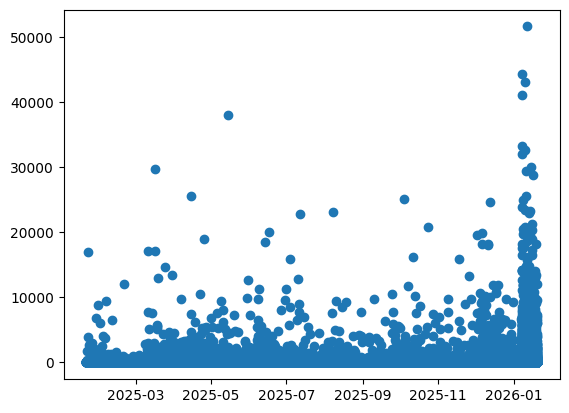

In [11]:
plt.scatter(df.posted_at, df.likes)

Hier is te zien dat er een grote piek is in januari. Dit is redelijk logisch, gezien in deze maand Renee Good is doodgeschoten, wat tot veel protesten heeft geleid. Om te zien hoeveel posts er binnen zijn gehaald per maand is de volgende grafiek opgezet:

<Axes: xlabel='posted_at'>

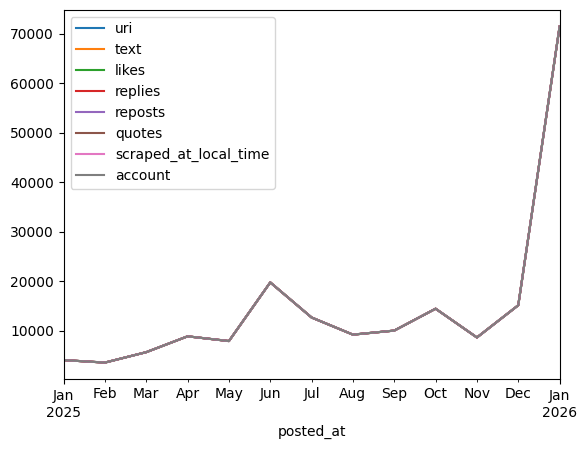

In [12]:
grouped = df.groupby(pd.Grouper(key='posted_at',freq='ME')).count()
grouped.plot()


Zoals hier te zien is, zijn er in vergelijking met de rest van het jaar, een grote hoeveelheid posts binnengehaald in januari. Dit zou kunnen komen door de dood van Renee Good, maar zou ook mogelijk door een bais in de scraper komen. Hierdoor is gekozen om nogmaals te scrapen met hogere limieten, om te kijken of de verdeling zo veranderd wordt.

Wel is er eerst een beetje schoonmaken uitgevoerd. Posts met de woorden 'ice cream' en 'ice spice' erin zijn weggehaald, zoals te zien is hieronder.

In [13]:
df[df['text'].str.contains('ice cream')]['text']

1792      He is also offering free ice cream for all,  painless dentistry, retirement at 40, oh and the deportation of anyone not white\n\nBBC News - Farage commits to reinstating winter fuel payment\nwww.bbc.com/news/article...                                                                                      
4024      $66,000 = 13,200 ice cream sundaes 🍨\n\nOr… one deportation.\n\nSame court dates when we use community alternatives. Less harm. Easy math.\ntinyurl.com/PraxisFo...\n\n#DignityForAll #What66kBuys #KeepFamiliesTogether\n1/2                                                                                   
8556      Raid done!! We beat Gallywix again, this time on heroic and on our alts 😊 now it’s time for a ice cream break and fan art time!🤔 I think I’ll watch the new predator movie tonight, then it’ll be fan arts time 😊                                                                                               
8696      I have only heard of raids in blue states. Th

In [14]:
i = df[df['text'].str.contains('ice spice')].index
j = df[df['text'].str.contains('ice cream')].index


df.drop(i)
df.drop(j)

uri  \
0       at://did:plc:zg3mbvhajrmif7g2lzuzwtta/app.bsky.feed.post/3mcs5ahki7s2w   
1       at://did:plc:ako55s6m4irasu37djcwhtgp/app.bsky.feed.post/3mcsqcgo2js2m   
2       at://did:plc:uo2fna47c4v6zcnklxfhcvjb/app.bsky.feed.post/3mcqnvw4sks2k   
3       at://did:plc:qtjpurf5fsptp3dhi52kksl6/app.bsky.feed.post/3mcrqcsityc2z   
4       at://did:plc:ysdibsjglggly2lpmoekupxd/app.bsky.feed.post/3mcs2yemua22k   
...                                                                        ...   
302779  at://did:plc:nkrf5naur7txeuvi3cwanexw/app.bsky.feed.post/3mbudryldjk2i   
302780  at://did:plc:4zsj6nz2httyjvrojcaiigjw/app.bsky.feed.post/3mc3m3ziuec2a   
302781  at://did:plc:dcf2j5r6ytmgxfeljuegrljj/app.bsky.feed.post/3mbwwtifnts27   
302782  at://did:plc:2kf2qj56o2vq7jfaq4x4ogp6/app.bsky.feed.post/3mcdbs5tw6k25   
302783  at://did:plc:b3uvpar5dn6b6apx7u3o6dky/app.bsky.feed.post/3mcf74oecs22h   

                                                                                                                                                                                                                                                                                                                  text  \
0       Here's staff on an ICE deportation flight giving us the finger on Nov 16, 2025, at Minneapolis - St. Paul International Airport. Berk Benson photo.                                                                                                                                                              
1       I saw a video of an ICE agent with an accent explaining to a man that he was being detained because HE had an accent. \n\nThe ICE agent clearly doesn’t realize that at any time, the whims of the dictator might mean he could be next in line for deportation, or worse…                                       
2       Nearly 90% of people in ICE custody are held in for-profit facilities. Transportation companies are openly banking tens of millions more as deportation flights expand.                                                                                                                                          
3       When ICE comes to the neighborhood, communities fight back. @meeshellchen.bsky.social takes inside the grassroots defense against deportation raids. www.thenation.com/article/acti...                                                                                                                           
4       On January 23rd, we take to the streets to challenge Palantir and Amazon for enabling ICE to rip our communities apart and fueling the machinery of mass deportation and family separation. psc-cuny.org/calendar/ice...                                                                                         
...                                                                                                                                                                                                                          ...                                                                                         
302779  Just heard that Truth Social post. Authored by The Peach POS💩. Read by Katy Tur, MS Now. \n\nAunt Tifa and Professional Agitators my azzzzzzzz, my precious. It was a murder committed by ICE. Unqualified ICE. Mentally unstable ICE. Volatile, racist ICE: very dangerous, unwell, unlawful, low IQ💍rungs🖕🪜🧊   
302780  If possible Trump will have ICE and DHS flood social media with what Kellyanne Conway used to call “alternative facts,” meaning it is BS. This is to prevent as many people as possible from seeing the truth. And if that doesn’t work then they’ll at least create doubt. You won’t know who to trust!         
302781  “…the Radical Left is threatening, assaulting, and targeting our Law Enforcement Officers and ICE Agents on a daily basis,” Trump said in a post on Truth Social on Wednesday.”\n\nI call bullshit.                                                             

# Wordclouds

Voor een eerste inzicht in de data en welke woorden het meest gebruikt worden, zijn er wordclouds gemaakt. De intentie hierachter was om te oefenen met deze data-analyse en om deze naast de topics te leggen, als vergelijking. Ook is er bekend dat er vanuit een topic een wordcloud gemaakt kan worden. Dit zal deze waarschijnlijk vervangen, wanneer gemaakt.

Er zijn twee versies gemaakt:
1. één waarbij de zoekopdrachten zijn behouden.
2. één waarbij de zoekopdrachten weg zijn gehaald

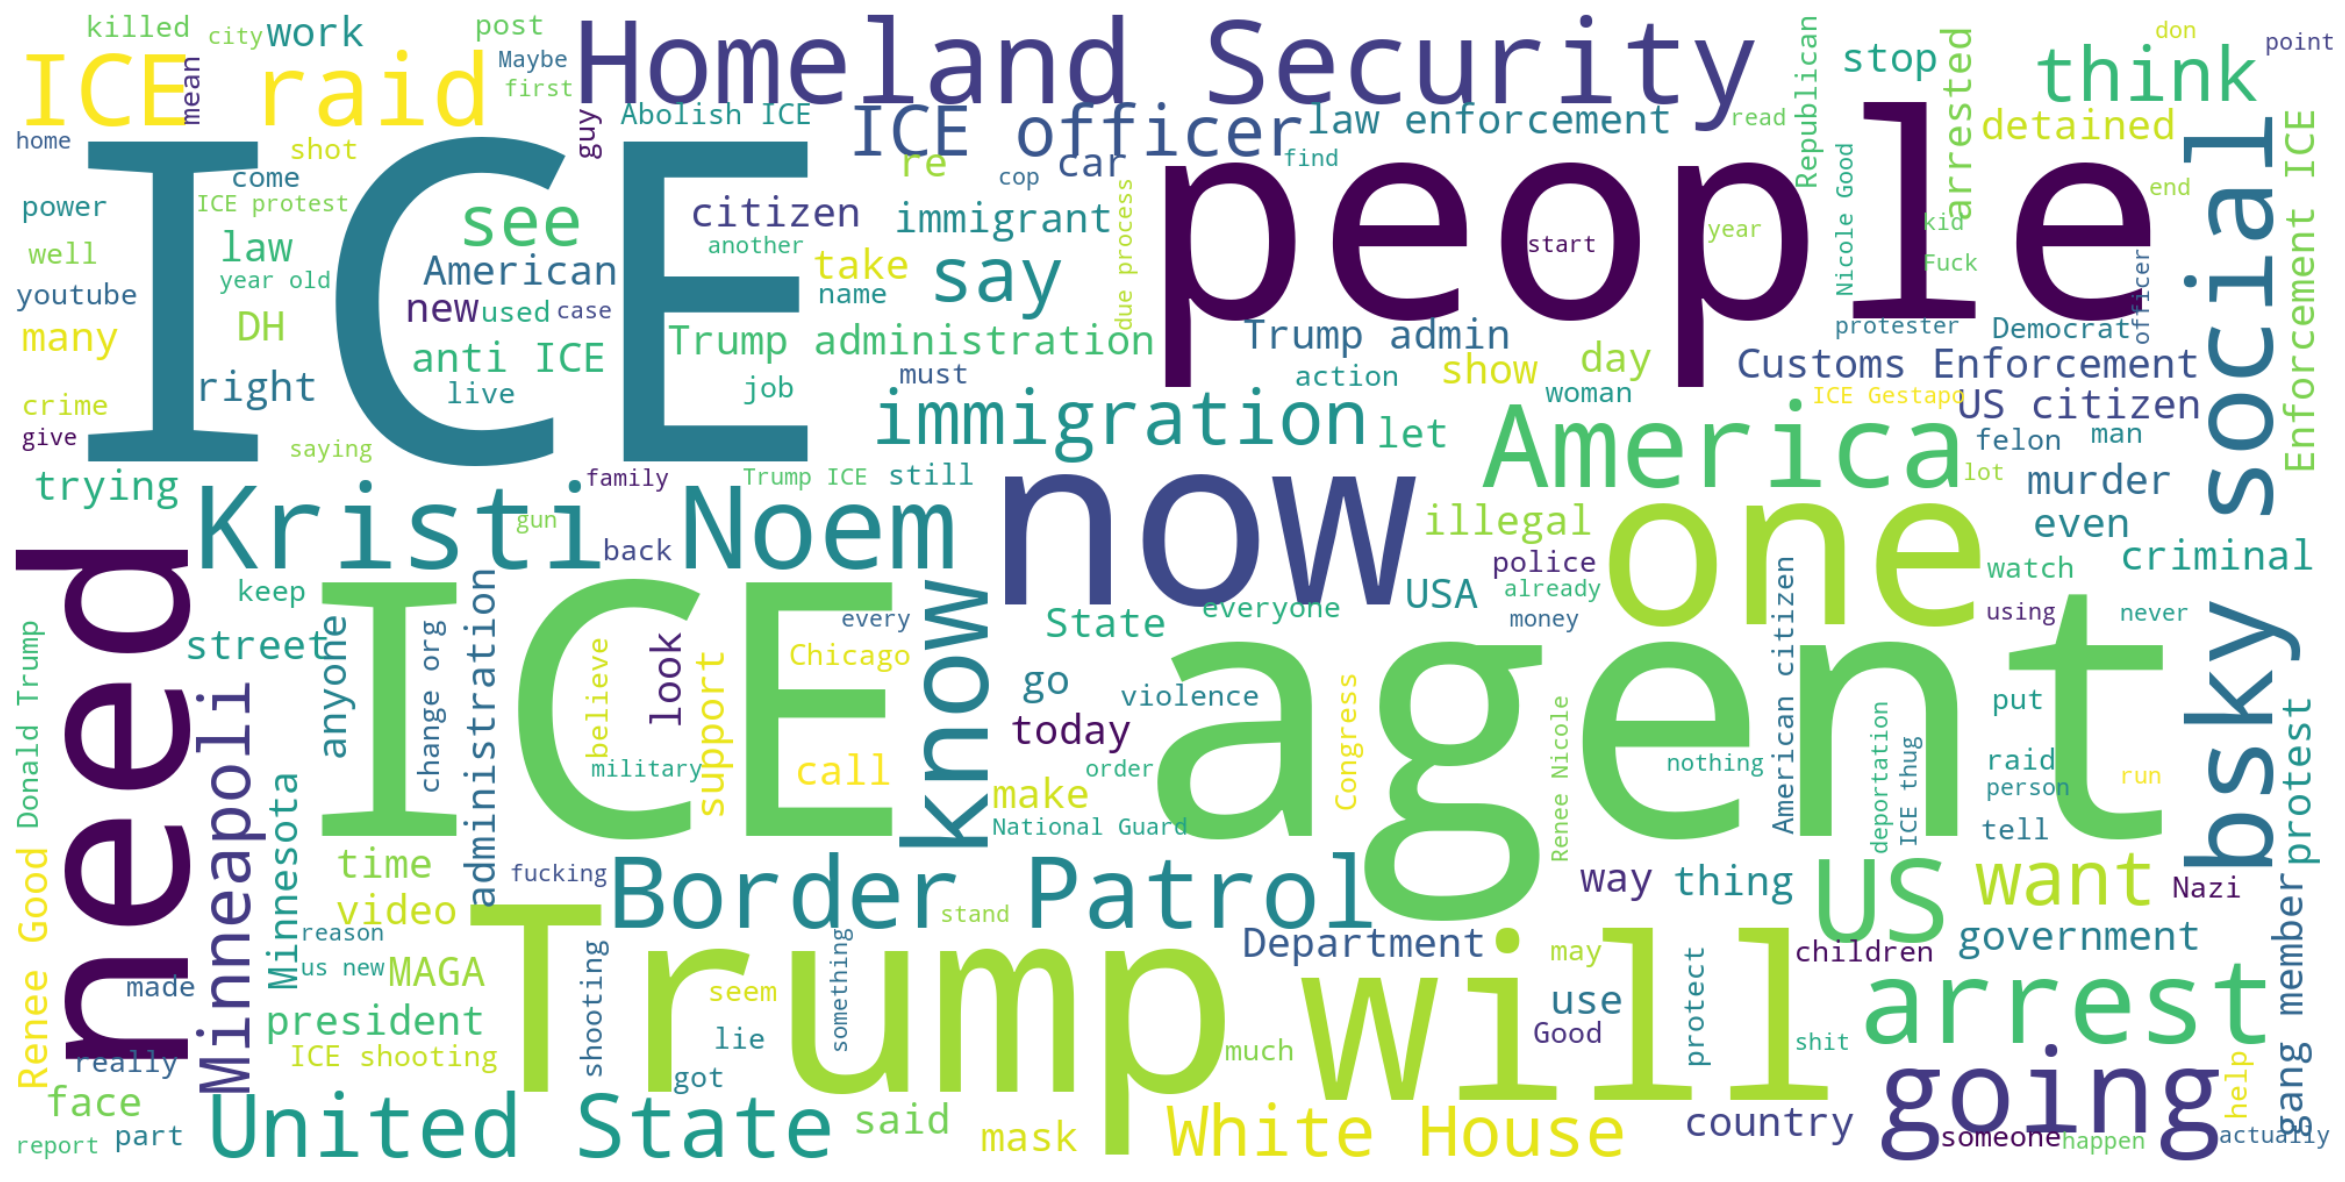

In [15]:
text = " ".join(i for i in df.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=True, scale=5, normalize_plurals = True, min_word_length = 2).generate(text)
plt.figure( figsize=(30,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

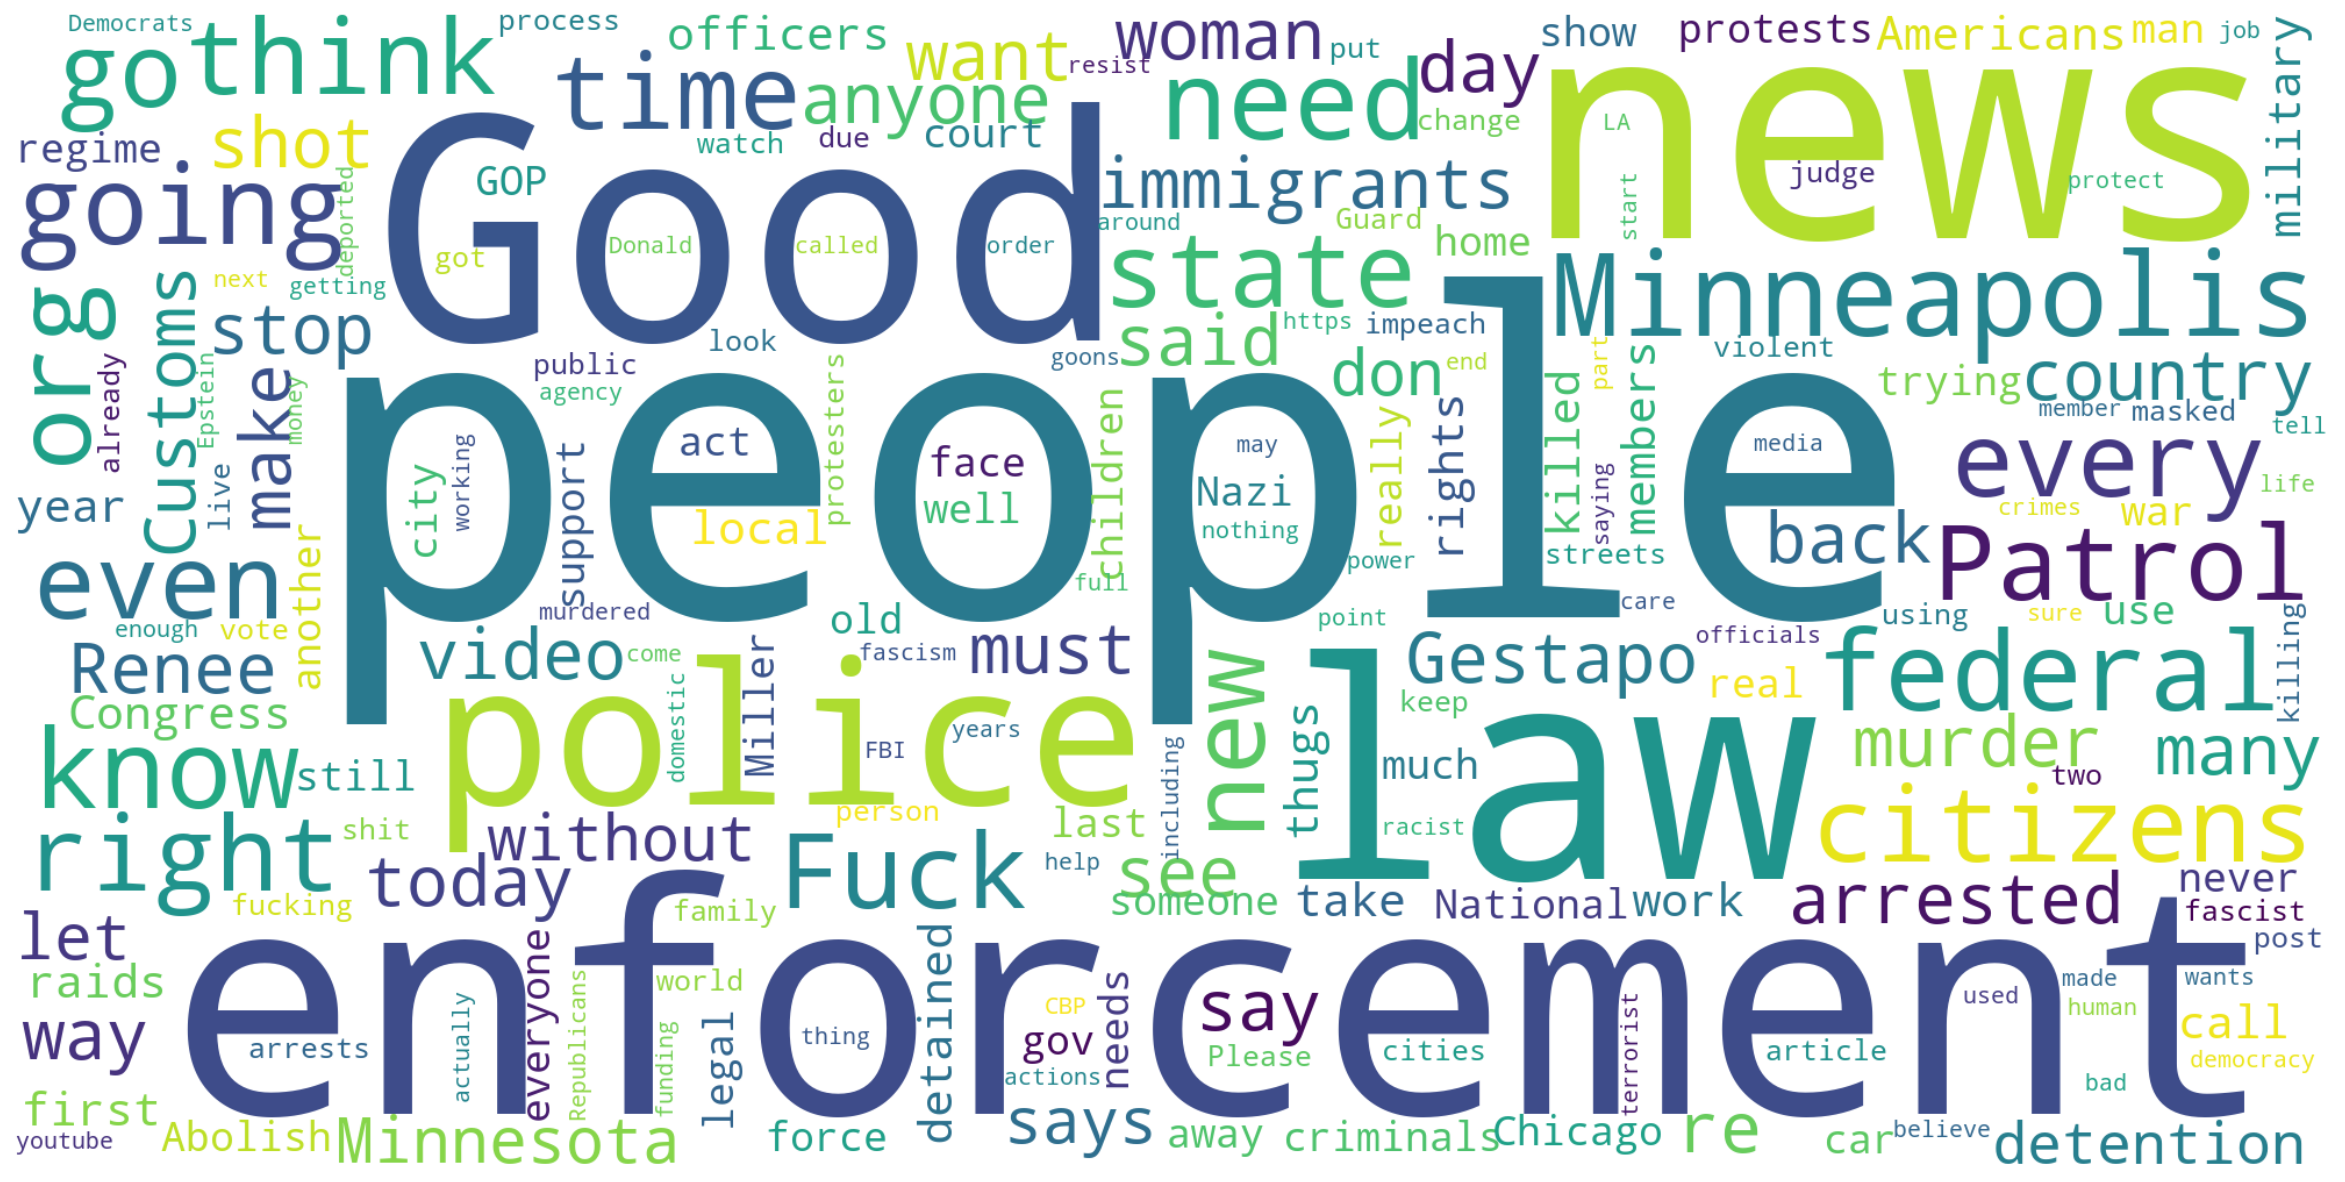

In [32]:
text = " ".join(i for i in df.text)
extra_words = {'department','homeland','security','united', 'states','white', 'house','enforcemnt','us','one','bsky','will','now','ice','deportation', 'raid', 'shooting', 'mask', 'agent','agents', 'officer', 'trump', 'administration', 'admin', 'dhs', 'immigration', 'usa', 'america', 'American', 'immigration', 'immigrant', 'president', 'illegal', 'alien', 'criminal', 'felon', 'arrest', 'gang', 'violence', 'Kristi', 'noem', 'border', 'convict', 'protest', 'citizen', 'government', 'anti', 'pro', 'maga', 'truth', 'social'}
stopwords = set(STOPWORDS | extra_words)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", scale=5, min_word_length = 2, collocations=False, normalize_plurals = False,).generate(text)
plt.figure( figsize=(30,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
df[df['text'].str.contains('People' or 'people')]

uri  \
50      at://did:plc:tq45nm435bl5lgzafpwdm53e/app.bsky.feed.post/3mcrntsqeds2d   
249     at://did:plc:w7er6cvh64jt4jhc56xemjjg/app.bsky.feed.post/3mcbqeiuyh22s   
496     at://did:plc:v7qxgsaicycbiy7kyjjkqkx7/app.bsky.feed.post/3mbckmgha2s2h   
536     at://did:plc:qvw6iezecm6rhcscmj7ehqlf/app.bsky.feed.post/3maz47sc6ik25   
771     at://did:plc:sxpionx2qekfltporvcd3x7a/app.bsky.feed.post/3m7m4wpcim224   
...                                                                        ...   
300400  at://did:plc:6hcjynfqzdcxok55zggaxeaj/app.bsky.feed.post/3ln3tyxbm3k2d   
300762  at://did:plc:rrcqp2nppbtgarmbe6mwyu6w/app.bsky.feed.post/3lxpdupzh6c2k   
301237  at://did:plc:do54tnooaq6gejxd7v7zkxig/app.bsky.feed.post/3ltuw67qoak2f   
302280  at://did:plc:dcv6ajwrfzzm43vn62qyxep6/app.bsky.feed.post/3lk2jpkm7b22m   
302712  at://did:plc:nc55kmwloitb7aqobamfpg7j/app.bsky.feed.post/3lkqsarbu5c2v   

                                                                                                                                                                                                                                                                                                                          text  \
50      Emma Goldman, american anarchist, wrote this in *1919!* about the country and its affairs. Re: ICE. The same thing over and over! Makes one think. Read it.\n\n"Deportation, Its Meaning and Menace: Last Message to the People of America by E Goldman and A Berkman"\nwww.marxists.org/reference/ar...                 
249     Just like the Holocaust museum in DC. \nThere will be another museum dedicated to the crimes of this regime. Including all the photos of violence and racism, illegal deportation and ICE raids. \nPeople will visit and wonder how this was allowed to happen.                                                          
496     When people know they could lose their freedom & family, they don't report crimes.\n\nAbuse victims stay silent because they fear detention & deportation.\n\nAbusers can traffic & torture using the threat of #ICE.\n\nPeople fear court & police.\n\nThis #ICELawlessness is making us less safe, not more safe.      
536     Beyond Dehumanizing’: #ICE Docs Expose Plan to Hold 80,000 People in Warehouses | Common Dreams\n\nICE unveils plan to repurpose warehouses for mass deportation operations, www.commondreams.org/news/inside-ice-detention-centers\n\nnedhamsonsecondlineviewofthenews.com/2025/12/25/b...\n\n#CampOfSaints 2.0         
771     We need action:\n• Airlines end deportation contracts\n• End inhumane treatment of detained immigrants\n• End Trump regime’s ICE terror campaign\n• Guarantee due process for every person on U.S. soil\nPeople deserve dignity, not disappearance. Add your name: seiu.co/de-ice-flights #SEIUPartner @seiu.org         
...                                                                                                                                                                                                                                                                                                                  ...         
300400  This will be true for all GOP, MAGA and ICE. We The People will make it so.\n\n"Of all these men, who but a year ago enjoyed wide influence or supreme power, not one could find a refuge in a continent united in hate against them."\n\nAnn Tusa, The Nuremberg Trial\nLike                                            
300762  Let’s just be very clear;\n\nALL National Guard Troops on US Soil To Entrap, Detain and Invade, Are Following ILLEGAL ORDERS*\n*ICE* Are Nazi Criminals*\n*DHS* Are Nazi MAGA*\n\nWE Have MORE Guns Than People here.\nSilencers are Tax-Free* \nNO Excuse for this\n\nARMED INVASION ENEMY FORCES NOW OCCUPY US SOIL.   
301237  The protests are happening weekly, sometimes daily. People are assembling wherever the ICE Nazis appear and they are steaming mad. There is serious momentum gathering across the countr

# Datacleaning pt.2 electric boogaloo

Er is uiteindelijk toch gekozen om de tweede dataset ook te importeren en te gaan gebruiken:

In [43]:
if os.path.isfile(path_2):
    df_2 = pd.read_json(path_2, lines=True, compression='gzip')
    print(df_2.head())
    print(df_2.tail())

                                                                      uri  \
0  at://did:plc:zg3mbvhajrmif7g2lzuzwtta/app.bsky.feed.post/3mcs5ahki7s2w   
1  at://did:plc:ako55s6m4irasu37djcwhtgp/app.bsky.feed.post/3mcsqcgo2js2m   
2  at://did:plc:qtjpurf5fsptp3dhi52kksl6/app.bsky.feed.post/3mcrqcsityc2z   
3  at://did:plc:ysdibsjglggly2lpmoekupxd/app.bsky.feed.post/3mcs2yemua22k   
4  at://did:plc:xthfrsjmikovkc2gtfw6n7fg/app.bsky.feed.post/3mcsagtdimc2p   

                                                                                                                                                                                                                                                                         text  \
0  Here's staff on an ICE deportation flight giving us the finger on Nov 16, 2025, at Minneapolis - St. Paul International Airport. Berk Benson photo.                                                                                                                  



Ook hier zullen de duplicates aan de hand van de 'uri' verwijderd worden.

In [44]:
df_2.drop_duplicates(subset=['uri'], keep='first', inplace=True, ignore_index=False)
df_2.tail()

uri  \
460321  at://did:plc:nkrf5naur7txeuvi3cwanexw/app.bsky.feed.post/3mbudryldjk2i   
460322  at://did:plc:4zsj6nz2httyjvrojcaiigjw/app.bsky.feed.post/3mc3m3ziuec2a   
460323  at://did:plc:dcf2j5r6ytmgxfeljuegrljj/app.bsky.feed.post/3mbwwtifnts27   
460324  at://did:plc:2kf2qj56o2vq7jfaq4x4ogp6/app.bsky.feed.post/3mcdbs5tw6k25   
460325  at://did:plc:b3uvpar5dn6b6apx7u3o6dky/app.bsky.feed.post/3mcf74oecs22h   

                                                                                                                                                                                                                                                                                                                  text  \
460321  Just heard that Truth Social post. Authored by The Peach POS💩. Read by Katy Tur, MS Now. \n\nAunt Tifa and Professional Agitators my azzzzzzzz, my precious. It was a murder committed by ICE. Unqualified ICE. Mentally unstable ICE. Volatile, racist ICE: very dangerous, unwell, unlawful, low IQ💍rungs🖕🪜🧊   
460322  If possible Trump will have ICE and DHS flood social media with what Kellyanne Conway used to call “alternative facts,” meaning it is BS. This is to prevent as many people as possible from seeing the truth. And if that doesn’t work then they’ll at least create doubt. You won’t know who to trust!         
460323  “…the Radical Left is threatening, assaulting, and targeting our Law Enforcement Officers and ICE Agents on a daily basis,” Trump said in a post on Truth Social on Wednesday.”\n\nI call bullshit.                                                                                                              
460324  Stollen is pretty tasty, and from his ancestral homeland. Maybe that's why Trump is always thinking about it?\n\nBtw he actually corrected his typos for once and reposted after deletion                                                                                                                        
460325  MAGA embodiment of “truth social” \n#ICE                                                                                                                                                                                                                                                                         

        likes  replies  reposts  quotes      scraped_at_local_time  \
460321  0      0        0        0      2026-02-07 22:27:06.107701   
460322  0      0        0        0      2026-02-07 22:27:06.591632   
460323  0      0        0        0      2026-02-07 22:27:06.591632   
460324  2      1        0        0      2026-02-07 22:27:06.591632   
460325  0      0        0        0      2026-02-07 22:27:06.591632   

                        account                 posted_at  
460321  binthed.bsky.social      2026-01-07T20:50:06.486Z  
460322  mphamner.bsky.social     2026-01-10T18:07:31.101Z  
460323  chris7ben.bsky.social    2026-01-08T21:36:17.204Z  
460324  localnotail.bsky.social  2026-01-13T19:24:20.580Z  
460325  john3-16.bsky.social     2026-01-14T13:41:51.696Z

En nogmaals data worden omgezet naar datetime objecten

In [45]:
df_2['posted_at'] = pd.to_datetime(df_2['posted_at'], format='mixed', utc=True)

Nu de datum van posten in datetime is gezet, kan er makkelijker een grafiek worden gemaakt van de hoeveelheid posts per maand:

<Axes: xlabel='Datum van posten', ylabel='Hoeveelheid posts'>

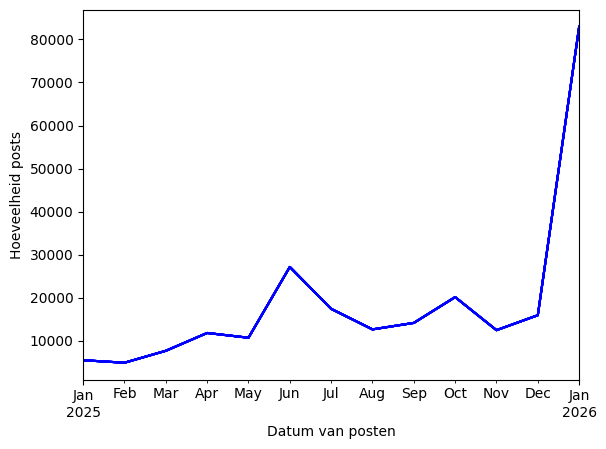

In [208]:
grouped = df_2.groupby(pd.Grouper(key='posted_at',freq='ME')).count()
grouped.plot(legend=False, color = 'b', xlabel='Datum van posten',ylabel='Hoeveelheid posts')

Ook hier is weer te zien dat er een grote piek is in januari

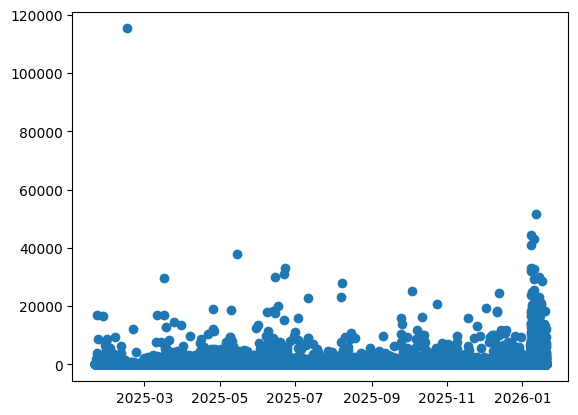

In [47]:
plt.scatter(df_2.posted_at, df_2.likes)

In [48]:
df_2[df_2["likes"]>115000]

uri  \
186613  at://did:plc:p7gxyfr5vii5ntpwo7f6dhe2/app.bsky.feed.post/3li6facwhtk2i   

                                                                                                                                                                                                                                                                                      text  \
186613  It is perfectly legal to know your rights and to educate others about them, too.\n\nEVERYONE in the United States, citizen or not, has rights. I will not allow this administration to intimidate us from helping you know about them.\n\nHere’s our shareable guide ⬇️: (pt. 1/2)   

         likes  replies  reposts  quotes      scraped_at_local_time  \
186613  115316  1821     34120    983    2026-02-07 20:34:40.843600   

                account                        posted_at  
186613  aoc.bsky.social 2025-02-14 23:47:35.893000+00:00

In [49]:
i = df_2[df_2['text'].str.contains('ice spice')].index
j = df_2[df_2['text'].str.contains('ice cream')].index


df_2.drop(i)
df_2.drop(j)

uri  \
0       at://did:plc:zg3mbvhajrmif7g2lzuzwtta/app.bsky.feed.post/3mcs5ahki7s2w   
1       at://did:plc:ako55s6m4irasu37djcwhtgp/app.bsky.feed.post/3mcsqcgo2js2m   
2       at://did:plc:qtjpurf5fsptp3dhi52kksl6/app.bsky.feed.post/3mcrqcsityc2z   
3       at://did:plc:ysdibsjglggly2lpmoekupxd/app.bsky.feed.post/3mcs2yemua22k   
4       at://did:plc:xthfrsjmikovkc2gtfw6n7fg/app.bsky.feed.post/3mcsagtdimc2p   
...                                                                        ...   
460321  at://did:plc:nkrf5naur7txeuvi3cwanexw/app.bsky.feed.post/3mbudryldjk2i   
460322  at://did:plc:4zsj6nz2httyjvrojcaiigjw/app.bsky.feed.post/3mc3m3ziuec2a   
460323  at://did:plc:dcf2j5r6ytmgxfeljuegrljj/app.bsky.feed.post/3mbwwtifnts27   
460324  at://did:plc:2kf2qj56o2vq7jfaq4x4ogp6/app.bsky.feed.post/3mcdbs5tw6k25   
460325  at://did:plc:b3uvpar5dn6b6apx7u3o6dky/app.bsky.feed.post/3mcf74oecs22h   

                                                                                                                                                                                                                                                                                                                  text  \
0       Here's staff on an ICE deportation flight giving us the finger on Nov 16, 2025, at Minneapolis - St. Paul International Airport. Berk Benson photo.                                                                                                                                                              
1       I saw a video of an ICE agent with an accent explaining to a man that he was being detained because HE had an accent. \n\nThe ICE agent clearly doesn’t realize that at any time, the whims of the dictator might mean he could be next in line for deportation, or worse…                                       
2       When ICE comes to the neighborhood, communities fight back. @meeshellchen.bsky.social takes inside the grassroots defense against deportation raids. www.thenation.com/article/acti...                                                                                                                           
3       On January 23rd, we take to the streets to challenge Palantir and Amazon for enabling ICE to rip our communities apart and fueling the machinery of mass deportation and family separation. psc-cuny.org/calendar/ice...                                                                                         
4       Your daily reminder that, besides many seeming to enjoy their thuggery, ICE agents also have a 3000/day deportation quota from Sociopath Stephen to meet. There ain’t no 3000 “violent criminals” a day to deport, so you do the math.                                                                           
...                                                                                                                                                                                                                                        ...                                                                           
460321  Just heard that Truth Social post. Authored by The Peach POS💩. Read by Katy Tur, MS Now. \n\nAunt Tifa and Professional Agitators my azzzzzzzz, my precious. It was a murder committed by ICE. Unqualified ICE. Mentally unstable ICE. Volatile, racist ICE: very dangerous, unwell, unlawful, low IQ💍rungs🖕🪜🧊   
460322  If possible Trump will have ICE and DHS flood social media with what Kellyanne Conway used to call “alternative facts,” meaning it is BS. This is to prevent as many people as possible from seeing the truth. And if that doesn’t work then they’ll at least create doubt. You won’t know who to trust!         
460323  “…the Radical Left is threatening, assaulting, and targeting our Law Enforcement Officers and ICE Agents on a daily basis,” Trump said in a post on Truth Social on Wednesday.”\n\nI call bullshit.                                                             

In [50]:
# EXPORTEERT SCHONE DATA NAAR JSONL!

# df_jsonl = df_2.to_json(orient="records", lines=True)
# data_dir = Path(os.getcwd() + r"/Data")
# data_dir.mkdir(parents=True, exist_ok=True)
# data_file = Path(data_dir / "bs-posts-2-clean.jsonl.gz")
# with gzip.open(data_file, "ab") as f:
#     f.write(df_jsonl.encode("utf-8"))

In [51]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired

In [52]:
## Setting up embedder
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
text = df_2.text.tolist()

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [53]:
## Pre-Embedding 
if not os.path.isfile(os.getcwd() + '/modellen/embeddings-bs.npy'):
    print('Geen opgeslagen embeddings gevonden, zelf aanmaken:')
    embeddings = sentence_model.encode(text, show_progress_bar=True)
    
    with open(os.getcwd() + '/modellen/embeddings-bs.npy', 'wb') as f:
        np.save(f, embeddings)
else:
    print('Opgeslagen embeddings gevonden, laden:')
    embeddings = np.load(os.getcwd() + '/modellen/embeddings-bs.npy')

In [60]:
## Setting up UMAP
umap_model = UMAP(n_neighbors=25, n_components=5, min_dist=0.05, metric='cosine', 
            random_state = 711)
    
## Setting up HDBSCAN 
hdbscan_model = HDBSCAN(min_cluster_size=50, min_samples=10, prediction_data=True)
    
representation_model = KeyBERTInspired()
    
topic_model = BERTopic(
    embedding_model=sentence_model, 
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model
)

embeddings = np.load(os.getcwd() + '/modellen/embeddings-bs.npy')

topics, probs = topic_model.fit_transform(text, embeddings)

In [61]:
topic_model.get_topic_info()

Topic   Count                                            Name  \
0   -1      130754  -1_immigration_ice_arrest_immigrant              
1    0      4662    0_ice_police_hiding_officers                     
2    1      4301    1_ice_investigation_citizen_terrorist            
3    2      4127    2_ice_gestapo_about_out                          
4    3      3746    3_ice_homeland_terrorist_terrorism               
..  ..       ...                                   ...               
460  459    50      459_iceoutofca_crisis_illegal_federalsupremacy   
461  460    50      460_boycottcbs_citizens_imprisons_kidnap         
462  461    50      461_protesting_latino_racism_hispanic            
463  462    50      462_immigration_ousted_intimidation_abiding      
464  463    50      463_immigration_detained_detention_visa          

                                                                                                                                   Representation  \
0    [immigration, ice, arrest, immigrant, citizen, citizens, police, enforcement, agents, agent]                                                   
1    [ice, police, hiding, officers, agents, pandemic, covid, agent, people, masks]                                                                 
2    [ice, investigation, citizen, terrorist, cold, justice, incident, agent, news, murder]                                                         
3    [ice, gestapo, about, out, what, trump, fuck, gop, regime, see]                                                                                
4    [ice, homeland, terrorist, terrorism, resign, news, agents, murder, agent, secretary]                                                          
..                                                                                     ...                                                          
460  [iceoutofca, crisis, illegal, federalsupremacy, authoritariandrift, fasciststatesofamerica, insurrectionists, colonized, govnewsom, tariffs]   
461  [boycottcbs, citizens, imprisons, kidnap, gestapo, captives, gov, gestapos, trump, madness]                                                    
462  [protesting, latino, racism, hispanic, racist, minorities, outrage, cops, victims, fostering]                                                  
463  [immigration, ousted, intimidation, abiding, debate, november, fear, naacpbucks, buckscounty, deputies]                                        
464  [immigration, detained, detention, visa, news, inhumane, cbcnews, march, 10news, after]                                                        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Representative_Docs  
0    [An American Citizen, held up by Border Patrol / ICE / Immigration Officials for 5 hours 👇 his story that shows what our country has become under Trump, It's Time to Stop the Violent Regime\n\nNo other president has put National Guard units in multiple cities at one time\n\nBorder Patrol, ICE and DHS attack squads in Multiple Cities to terrorize citizens\n\nIf the President does not pull back his threats, we could have a war government against the people, Fully

In [ ]:
# topic_model.save(
#     path=os.getcwd() + '/modellen/topic-model-bs',
#     serialization="safetensors",
#     save_ctfidf=True,
#     save_embedding_model="all-MiniLM-L6-v2"
# )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 463/463 [02:47<00:00,  2.77it/s]


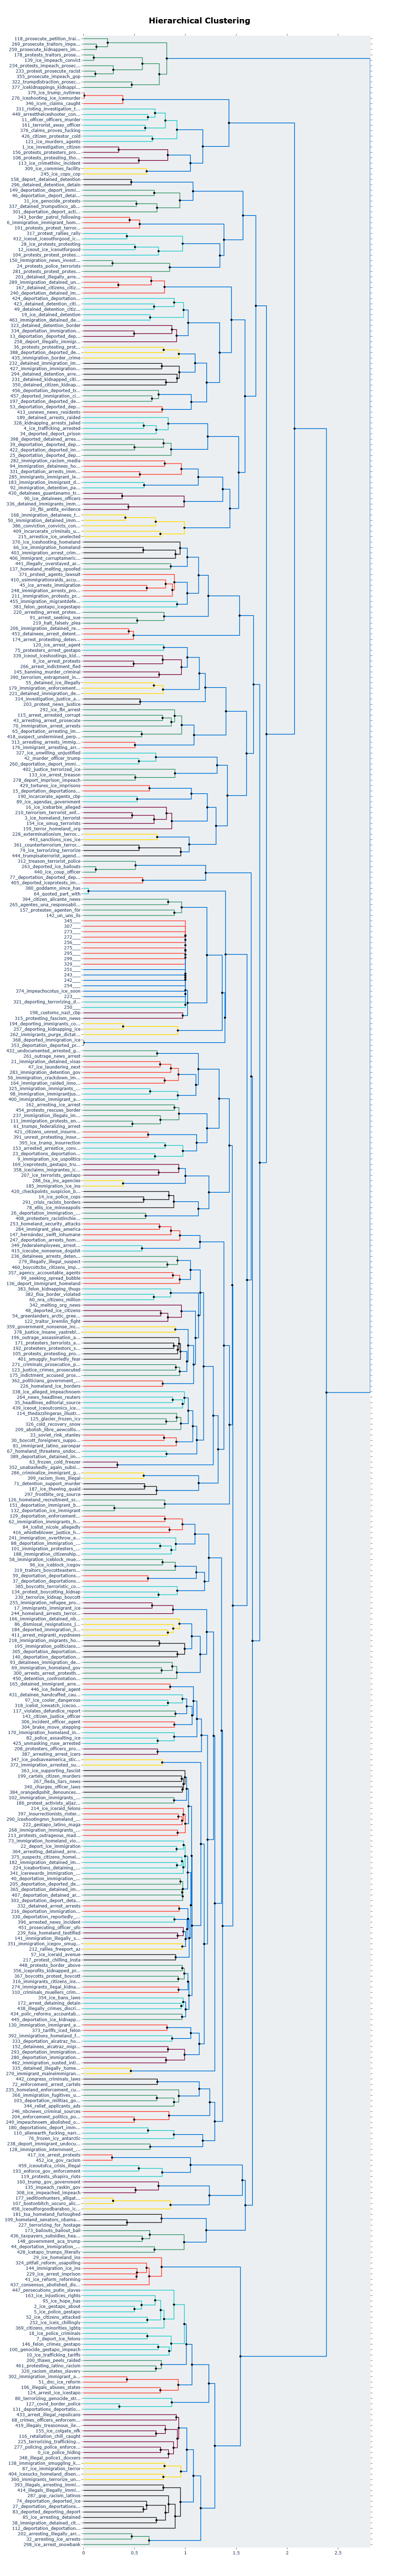

In [62]:
hierarchical_topics = topic_model.hierarchical_topics(text,)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics,
    width=900)

Er zijn met dit model veel outliers en veel clusters. Deze kunnen beiden verminderd worden door min_cluster_size op te hogen en min_samples lager te zetten dan min_cluster_size:

In [65]:
## Setting up UMAP
umap_model = UMAP(n_neighbors=25, n_components=5, min_dist=0.05, metric='cosine', 
            random_state = 711)
    
## Setting up HDBSCAN 
hdbscan_model = HDBSCAN(min_cluster_size=100, min_samples=20, prediction_data=True)
    
representation_model = KeyBERTInspired()
    
topic_model = BERTopic(
    embedding_model=sentence_model, 
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model
)

embeddings = np.load(os.getcwd() + '/modellen/embeddings-bs.npy')

topics, probs = topic_model.fit_transform(text, embeddings)

In [67]:
topic_model.get_topic_info()

Topic   Count                                            Name  \
0   -1      130645  -1_immigration_ice_arrest_immigrant              
1    0      7979    0_ice_police_enforcement_hiding                  
2    1      4810    1_ice_immigration_homeland_congress              
3    2      4411    2_ice_enforcement_terrorist_investigation        
4    3      4190    3_ice_gestapo_trump_gop                          
..  ..       ...                        ...                          
235  234    102     234_detained_illegally_citizenship_citizen       
236  235    101     235_deporting_immigrants_kidnapping_ice          
237  236    101     236_homeland_news_kristi_smartnews               
238  237    100     237_deportation_immigration_detained_illegally   
239  238    100     238_felon_sanctioned_racist_racism               

                                                                                                       Representation  \
0    [immigration, ice, arrest, immigrant, citizen, citizens, police, enforcement, agents, agent]                       
1    [ice, police, enforcement, hiding, officers, agents, covid, officer, agent, people]                                
2    [ice, immigration, homeland, congress, border, cuts, senate, next, abolish, cut]                                   
3    [ice, enforcement, terrorist, investigation, citizen, cold, away, incident, officer, justice]                      
4    [ice, gestapo, trump, gop, fascist, regime, republicans, maga, nazis, republican]                                  
..                                                                                 ...                                  
235  [detained, illegally, citizenship, citizen, jail, detainer, latino, arrested, law, carlos]                         
236  [deporting, immigrants, kidnapping, ice, trumpisacriminal, dismantling, impeachthemf, ignoring, gov, felon47]      
237  [homeland, news, kristi, smartnews, noem, department, bust, pitchfork, country, instagram]                         
238  [deportation, immigration, detained, illegally, detention, citizenship, citizen, arrested, kidnapped, attorneys]   
239  [felon, sanctioned, racist, racism, trump, terrorist, ice, nationalist, police, supremacists]                      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Representative_Docs  
0    [So this is how many people they have in ice detention right now look at the number of illegal immigrants convicted or charged with a crime that number Which is roughly 30,000 people is what we all voted for not the other 20,000 people being swooped up. We did not vote for that., So are we all supposed to just go to work and pretend an ICE agent didn't shoot a woman in the face and will most likely get away with it? And also ignore the Portland shooting from Border Patrol that occurred not 3 hours ago?\n\nAnd if so... how?, For example, the Department of Homeland Security is actually saying that not all of the people conducting these immigration raids are ICE. Some are actually Border Patrol officers, which is a different agency but they do the same job.]                                                                  

Nog steeds heel veel outliers, welke verminderd moeten worden. Er zijn wel minder clusters, wat een van de doelen was.

In [70]:
new_topics = topic_model.reduce_outliers(text, topics, strategy="embeddings")

In [71]:
topic_model.update_topics(text, topics=new_topics)

2026-02-20 14:03:47,588 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [72]:
topic_model.get_topic_info()

Topic  Count                                  Name  \
0    0      8678   0_mask_masks_wear_wearing              
1    1      7236   1_funding_budget_billion_money         
2    2      5352   2_renee_good_ross_nicole               
3    3      4979   3_maga_fuck_they_are                   
4    4      7526   4_protest_protests_anti_protesters     
..  ..       ...                                  ...     
234  234    215    234_lopez_gomez_juan_carlos            
235  235    194    235_isn_retaliating_upholding_fixing   
236  236    298    236_song_zach_bryan_lyrics             
237  237    275    237_maryland_dulce_her_morales         
238  238    427    238_kkk_klan_white_no                  

                                                                                      Representation  \
0    [mask, masks, wear, wearing, masked, agents, face, they, their, hide]                             
1    [funding, budget, billion, money, bill, dems, democrats, government, for, fund]                   
2    [renee, good, ross, nicole, jonathan, agent, her, shot, murdered, killed]                         
3    [maga, fuck, they, are, all, is, their, you, and, the]                                            
4    [protest, protests, anti, protesters, peaceful, at, protesting, today, rally, indivisible]        
..                                                                                          ...        
234  [lopez, gomez, juan, carlos, florida, certificate, birth, born, unauthorized, citizen]            
235  [isn, retaliating, upholding, fixing, dismantling, ignoring, doge, felon47, helping, fucktrump]   
236  [song, zach, bryan, lyrics, music, country, songs, snippet, new, star]                            
237  [maryland, dulce, her, morales, citizen, she, birth, certificate, consuelo, diaz]                 
238  [kkk, klan, white, no, supremacy, racist, boys, klux, usa, proud]                                 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Representative_Docs  
0    [Ice agents without their mask, If you want to wear a mask, wear one. Even ICE thugs wear masks., I dont care if its a regular mask or some medical masks.  Since when did it become illegal to wear a mask?  If its illegal then arrest every ice agent and police agent wearing one?  Now the Government can tell us we cant wear a mask?]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1    [Remember Trump Admin is asking for more money for ICE in a potential end of January budget shut down. \n\nDems in Congress stop funding these sins, we will remember you and we will run candidates who won't!!, How will you vote on DHS funding for ICE?, Dems-Shut down the government funding o

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:02<00:00, 95.33it/s]


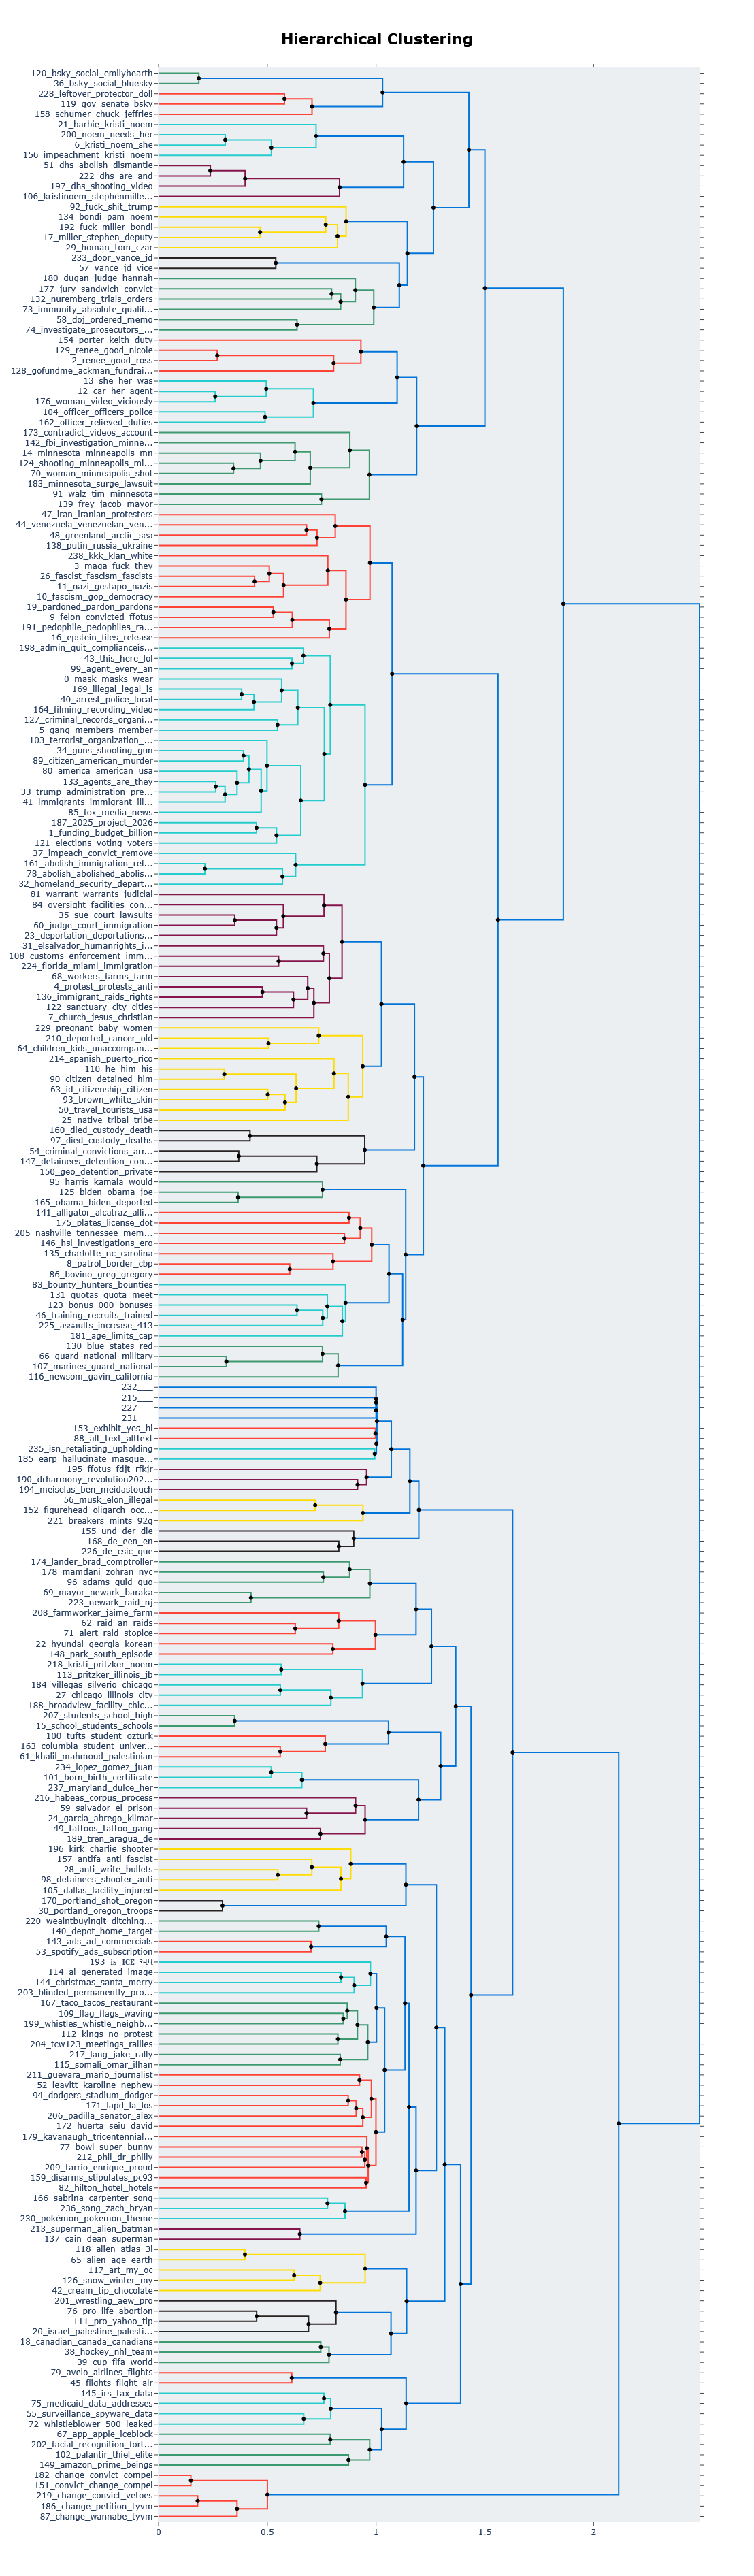

In [73]:
hierarchical_topics = topic_model.hierarchical_topics(text,)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics,
    width=900)

In [89]:
topic_model.save(
    path=os.getcwd() + '/modellen/topic-model-bs-2-reduced',
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model="all-MiniLM-L6-v2"
)

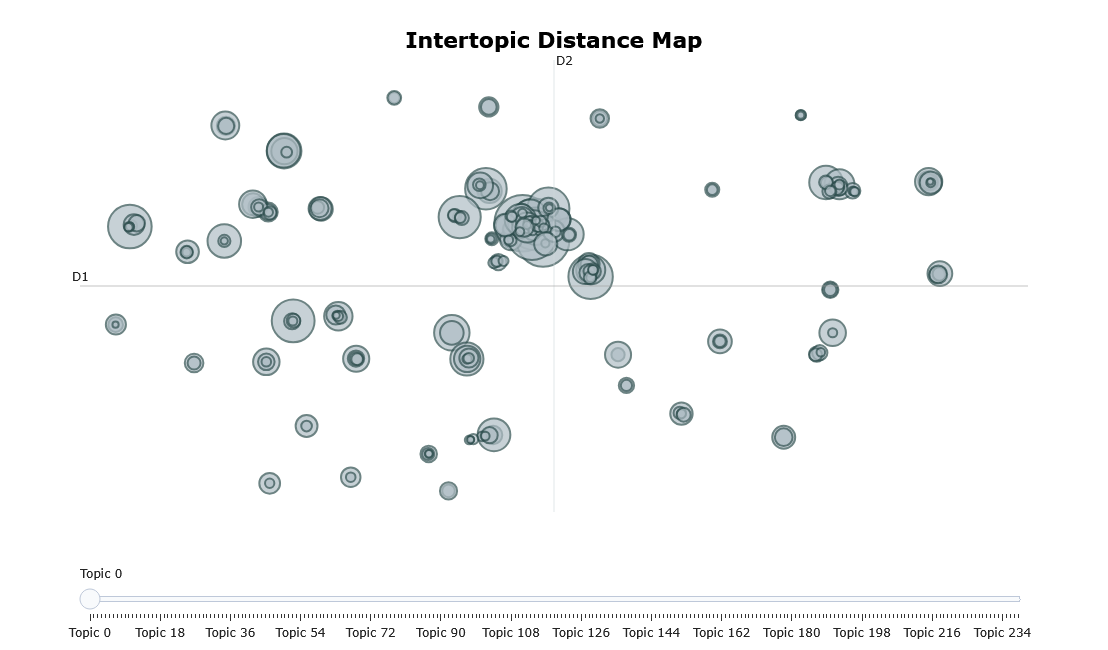

In [211]:
topic_model.visualize_topics()

In [88]:
df_2["Topic"] = new_topics
df_2.head()

uri  \
0  at://did:plc:zg3mbvhajrmif7g2lzuzwtta/app.bsky.feed.post/3mcs5ahki7s2w   
1  at://did:plc:ako55s6m4irasu37djcwhtgp/app.bsky.feed.post/3mcsqcgo2js2m   
2  at://did:plc:qtjpurf5fsptp3dhi52kksl6/app.bsky.feed.post/3mcrqcsityc2z   
3  at://did:plc:ysdibsjglggly2lpmoekupxd/app.bsky.feed.post/3mcs2yemua22k   
4  at://did:plc:xthfrsjmikovkc2gtfw6n7fg/app.bsky.feed.post/3mcsagtdimc2p   

                                                                                                                                                                                                                                                                         text  \
0  Here's staff on an ICE deportation flight giving us the finger on Nov 16, 2025, at Minneapolis - St. Paul International Airport. Berk Benson photo.                                                                                                                          
1  I saw a video of an ICE agent with an accent explaining to a man that he was being detained because HE had an accent. \n\nThe ICE agent clearly doesn’t realize that at any time, the whims of the dictator might mean he could be next in line for deportation, or worse…   
2  When ICE comes to the neighborhood, communities fight back. @meeshellchen.bsky.social takes inside the grassroots defense against deportation raids. www.thenation.com/article/acti...                                                                                       
3  On January 23rd, we take to the streets to challenge Palantir and Amazon for enabling ICE to rip our communities apart and fueling the machinery of mass deportation and family separation. psc-cuny.org/calendar/ice...                                                     
4  Your daily reminder that, besides many seeming to enjoy their thuggery, ICE agents also have a 3000/day deportation quota from Sociopath Stephen to meet. There ain’t no 3000 “violent criminals” a day to deport, so you do the math.                                       

   likes  replies  reposts  quotes      scraped_at_local_time  \
0  240    3        60       2      2026-02-07 19:17:47.663351   
1  58     1        2        0      2026-02-07 19:17:47.663351   
2  51     1        21       1      2026-02-07 19:17:47.663351   
3  36     2        16       0      2026-02-07 19:17:47.663351   
4  59     2        18       0      2026-02-07 19:17:47.663351   

                       account                        posted_at  Topic  
0  ottergoose.net              2026-01-19 17:12:47.904000+00:00  45     
1  g4techtalker.bsky.social    2026-01-19 22:53:55.180000+00:00  110    
2  thenation.com               2026-01-19 13:21:27.853000+00:00  136    
3  psc-cuny.org                2026-01-19 16:32:26.983000+00:00  102    
4  jonbowzerbauman.bsky.social 2026-01-19 18:10:02.814000+00:00  23

In [90]:
df_topics = topic_model.get_topic_info()

In [91]:
df_topics

Topic  Count                                  Name  \
0    0      8678   0_mask_masks_wear_wearing              
1    1      7236   1_funding_budget_billion_money         
2    2      5352   2_renee_good_ross_nicole               
3    3      4979   3_maga_fuck_they_are                   
4    4      7526   4_protest_protests_anti_protesters     
..  ..       ...                                  ...     
234  234    215    234_lopez_gomez_juan_carlos            
235  235    194    235_isn_retaliating_upholding_fixing   
236  236    298    236_song_zach_bryan_lyrics             
237  237    275    237_maryland_dulce_her_morales         
238  238    427    238_kkk_klan_white_no                  

                                                                                      Representation  \
0    [mask, masks, wear, wearing, masked, agents, face, they, their, hide]                             
1    [funding, budget, billion, money, bill, dems, democrats, government, for, fund]                   
2    [renee, good, ross, nicole, jonathan, agent, her, shot, murdered, killed]                         
3    [maga, fuck, they, are, all, is, their, you, and, the]                                            
4    [protest, protests, anti, protesters, peaceful, at, protesting, today, rally, indivisible]        
..                                                                                          ...        
234  [lopez, gomez, juan, carlos, florida, certificate, birth, born, unauthorized, citizen]            
235  [isn, retaliating, upholding, fixing, dismantling, ignoring, doge, felon47, helping, fucktrump]   
236  [song, zach, bryan, lyrics, music, country, songs, snippet, new, star]                            
237  [maryland, dulce, her, morales, citizen, she, birth, certificate, consuelo, diaz]                 
238  [kkk, klan, white, no, supremacy, racist, boys, klux, usa, proud]                                 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Representative_Docs  
0    [Ice agents without their mask, If you want to wear a mask, wear one. Even ICE thugs wear masks., I dont care if its a regular mask or some medical masks.  Since when did it become illegal to wear a mask?  If its illegal then arrest every ice agent and police agent wearing one?  Now the Government can tell us we cant wear a mask?]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1    [Remember Trump Admin is asking for more money for ICE in a potential end of January budget shut down. \n\nDems in Congress stop funding these sins, we will remember you and we will run candidates who won't!!, How will you vote on DHS funding for ICE?, Dems-Shut down the government funding o

In [96]:
# export van topics en data

df_topics.to_json('../Data/topic_modeling/bs-topics.json.gz', orient='records', compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})
df_2.to_json('../Data/topic_modeling/bs-clean-2-withtopics.json.gz', orient='records', compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

# Visualisaties

Nu de data is verwerkt, kunnen er een aantal visualisaties worden gemaakt. Gezien het doel is om te zien welk topic meer engagement krijgt, kunnen we dit op de volgende manier visualiseren:

In [213]:
grouped_1 = df_2.groupby('Topic', as_index=False)[['likes','replies','reposts','quotes']].sum().sort_values(by='likes', ascending=False)
grouped_1 = pd.merge(grouped_1, df_topics[['Topic','Count']], on='Topic', how='inner')
grouped_1 = grouped_1.astype({'Topic':str})

grouped_top = grouped_1.head(10)
grouped_top

Topic   likes  replies  reposts  quotes  Count
0  2     642791  37333    215503   18786   5352 
1  4     428690  12549    110086   6437    7526 
2  0     315310  16541    85865    7269    8678 
3  14    309883  15846    97684    6773    2817 
4  12    305377  16299    88773    7546    3276 
5  90    304151  14475    136499   11440   2667 
6  1     285814  15093    77378    6566    7236 
7  41    238515  10325    68993    3732    4810 
8  89    238420  10561    76056    4179    2917 
9  6     232240  17954    73493    6527    4773

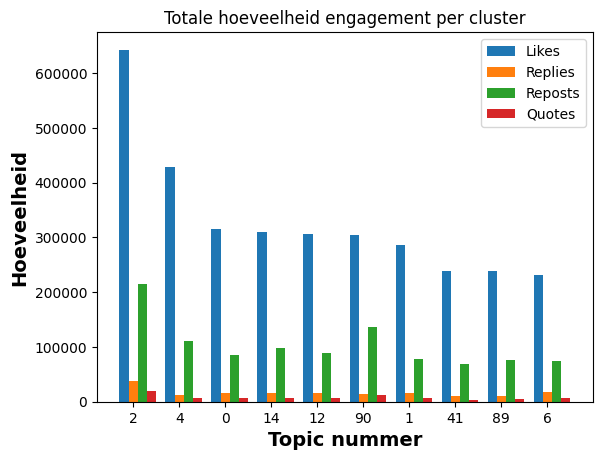

In [214]:
x_1 = grouped_top['Topic']
y_1 = grouped_top['likes']
y_2 = grouped_top['replies']
y_3 = grouped_top['reposts']
y_4 = grouped_top['quotes']

bar_width = 0.20
x = np.arange(len(grouped_top))

plt.bar(x - bar_width, y_1, width=bar_width, label='Likes')
plt.bar(x, y_2, width=bar_width, label='Replies')
plt.bar(x + bar_width, y_3, width=bar_width, label='Reposts')
plt.bar(x + 2*bar_width, y_4,width = bar_width, label='Quotes')

plt.xlabel('Topic nummer', fontweight='bold',fontsize=14)
plt.ylabel('Hoeveelheid', fontweight='bold',fontsize=14)
plt.xticks(x, x_1)
plt.legend()
plt.title("Totale hoeveelheid engagement per cluster")
plt.show()

De topics hebben allemaal ook veel posts, door het gemiddelde per post te nemen, kan dit beter gerepresenteerd worden.

In [159]:
df_topics[df_topics['Topic'].isin([2,4,0,14,12,90,1,41,98,6])][['Topic','Count','Representation']]

Topic  Count  \
0   0      8678    
1   1      7236    
2   2      5352    
4   4      7526    
6   6      4773    
12  12     3276    
14  14     2817    
41  41     4810    
90  90     2667    
98  98     605     

                                                                                         Representation  
0   [mask, masks, wear, wearing, masked, agents, face, they, their, hide]                                
1   [funding, budget, billion, money, bill, dems, democrats, government, for, fund]                      
2   [renee, good, ross, nicole, jonathan, agent, her, shot, murdered, killed]                            
4   [protest, protests, anti, protesters, peaceful, at, protesting, today, rally, indivisible]           
6   [kristi, noem, she, her, secretary, com, ice, puppy, rawstory, www]                                  
12  [car, her, agent, vehicle, she, was, officer, shot, woman, video]                                    
14  [minnesota, minneapolis, mn, minnesotans, state, insurrection, in, city, to, trump]                  
41  [immigrants, immigrant, illegal, immigration, undocumented, they, are, criminals, citizens, people]  
90  [citizen, detained, him, old, was, arrested, year, us, he, kidnapped]                                
98  [detainees, shooter, anti, shot, were, bullets, only, shooting, shoot, bullet]

In [217]:
grouped_1 = grouped_1.astype({'Topic':int})

grouped_1['gem_likes'] = grouped_1['likes']/grouped_1['Count']
grouped_1['gem_replies'] = grouped_1['replies']/grouped_1['Count']
grouped_1['gem_reposts'] = grouped_1['reposts']/grouped_1['Count']
grouped_1['gem_quotes'] = grouped_1['quotes']/grouped_1['Count']

grouped_1 = grouped_1.sort_values(by ='gem_likes', ascending=False)
grouped_top = grouped_1.head(10)
grouped_top

Topic   likes  replies  reposts  quotes  Count   gem_likes  gem_replies  \
40   154    77498   1940     41014    1495    224    345.973214  8.660714      
57   229    61126   2028     23906    1308    357    171.221289  5.680672      
21   129    113405  3487     32870    2099    700    162.007143  4.981429      
18   197    135322  6386     46060    3406    891    151.876543  7.167228      
70   115    49064   2675     17643    1910    324    151.432099  8.256173      
95   166    31578   681      5793     618     223    141.605381  3.053812      
106  218    26096   1381     6519     399     189    138.074074  7.306878      
32   61     90816   2502     28333    2440    662    137.184290  3.779456      
85   205    35933   2141     13730    1003    265    135.596226  8.079245      
66   74     55533   2378     20098    1246    410    135.446341  5.800000      

     gem_reposts  gem_quotes  
40   183.098214   6.674107    
57   66.963585    3.663866    
21   46.957143    2.998571    
18   51.694725    3.822671    
70   54.453704    5.895062    
95   25.977578    2.771300    
106  34.492063    2.111111    
32   42.799094    3.685801    
85   51.811321    3.784906    
66   49.019512    3.039024

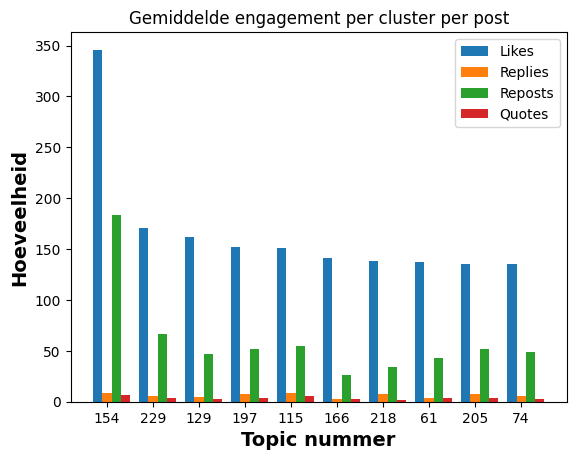

In [222]:
x_1 = grouped_top['Topic']
y_1 = grouped_top['gem_likes']
y_2 = grouped_top['gem_replies']
y_3 = grouped_top['gem_reposts']
y_4 = grouped_top['gem_quotes']

bar_width = 0.20
x = np.arange(len(grouped_top))

plt.bar(x - bar_width, y_1, width=bar_width, label='Likes')
plt.bar(x, y_2, width=bar_width, label='Replies')
plt.bar(x + bar_width, y_3, width=bar_width, label='Reposts')
plt.bar(x + 2*bar_width, y_4,width = bar_width, label='Quotes')

plt.ylabel('Hoeveelheid', fontweight='bold',fontsize=14)
plt.xlabel("Topic nummer", fontweight='bold',fontsize=14)
plt.xticks(x, x_1)
plt.legend()
plt.title('Gemiddelde engagement per cluster per post')
plt.show()

In [170]:
df_topics[df_topics['Topic'].isin([154,229,129,197,115,166,218,61,205,74])][['Topic','Count','Representation']]

Topic  Count  \
61   61     662     
74   74     410     
115  115    324     
129  129    700     
154  154    224     
166  166    223     
197  197    891     
205  205    265     
218  218    189     
229  229    357     

                                                                                        Representation  
61   [khalil, mahmoud, palestinian, columbia, activist, university, student, pro, detained, detention]  
74   [investigate, prosecutors, doj, resigned, widow, quit, division, shooting, probe, push]            
115  [somali, omar, ilhan, somalis, minnesota, minneapolis, garbage, community, son, fraud]             
129  [renee, good, nicole, minneapolis, protest, vigil, protests, killed, killing, fatal]               
154  [porter, keith, duty, eve, killed, off, jr, year, black, northridge]                               
166  [sabrina, carpenter, song, juno, house, music, video, white, using, slams]                         
197  [dhs, shooting, video, lying, minneapolis, lie, shot, was, story, claims]                          
205  [nashville, tennessee, memphis, tn, connell, freddie, rock, county, highway, kid]                  
218  [kristi, pritzker, noem, restrooms, halloween, jb, bathroom, whines, chicago, use]                 
229  [pregnant, baby, women, mother, her, birth, woman, citizen, 866, detention]

In [284]:
temp = df_2[df_2['Topic'] == 229 ].sort_values(by='likes',ascending=False)
temp[temp["text"].str.contains('866')]
# temp

uri  \
128733  at://did:plc:zgws7v6sk5vsndr473qdde7n/app.bsky.feed.post/3mc5lrna7is2m   
131015  at://did:plc:3rfmyade35win2twlshyfvkt/app.bsky.feed.post/3m7vrsdp4wc2m   
131040  at://did:plc:z5umo6wcupxrgrcst26ywfd4/app.bsky.feed.post/3m7tqb4day225   
128366  at://did:plc:xrsv7fsbam5cvqyh4mb2ir2y/app.bsky.feed.post/3mcb5wz5rek25   
131041  at://did:plc:enrbdi3edl54fy34xbvpalsq/app.bsky.feed.post/3m7tiwo3bbc27   
130863  at://did:plc:5vjbua7nlnyasb62lxe42e37/app.bsky.feed.post/3magygggg2c2g   
130982  at://did:plc:ieiynhfwlqz4fsndvq3j53qi/app.bsky.feed.post/3ma2intdnbc27   
131069  at://did:plc:nuzej6pchsv4b7iss5wytmap/app.bsky.feed.post/3m7sp5cwjnc2m   
131039  at://did:plc:j5errtzquwl2zibzwfvmjmzp/app.bsky.feed.post/3m7uvymmdek2u   
135454  at://did:plc:ybgfdn4orunozey6s3fdnvdg/app.bsky.feed.post/3m7syjnge4s2o   

                                                                                                                                                                                                                                                                                                               text  \
128733  ICE is asking for people to quit calling its hotline to report an undocumented girl named 'Anne Frank' hiding in the attics of Republican lawmakers.\nPlease don't call 1-866-DHS-2-ICE (1-866-347-2423) for this reason, or to report pregnant foreigners seeking shelter in your local manger.              
131015  ICE is asking for people to quit calling its hotline to report an undocumented girl named 'Anne Frank' hiding in the attics of Republican lawmakers.\n\nPlease don't call 1-866-DHS-2-ICE (1-866-347-2423) for this reason, or to report pregnant foreigners seeking shelter in your local manger.            
131040  ICE is asking for people to quit calling its hotline to report an undocumented girl named 'Anne Frank' hiding in the attics of Republican lawmakers.  \n\nPlease don't call  1-866-DHS-2-ICE (1-866-347-2423) for this reason, or to report pregnant foreigners seeking shelter in your local manger.         
128366  ICE is asking for people to quit calling its hotline to report an undocumented girl named "Anne Frank' hiding in the attics of Republican lawmakers.\nPlease don't call 1-866-\nDHS-2-ICE\n(1-866-347-2423) for this reason, or to report pregnant foreigners seeking shelter in your local manger.           
131041  ICE is asking for people to quit calling its hotline to report an undocumented girl named 'Anne Frank' hiding in the attics of Republican lawmakers.  \n\nPlease don't call  1-866-DHS-2-ICE (1-866-347-2423) for this reason, or to report pregnant foreigners seeking shelter in your local manger.         
130863  ICE is asking for people to quit calling its hotline to report an undocumented girl named\n'Anne Frank' hiding in the attics of Republican lawmakers.\nPlease don't call\n1-866-DHS-2-ICE\n(1-866-347-2423) for this reason, or to report pregnant foreigners seeking shelter in your local manger.           
130982  PSA;\nICE is asking for people to quit calling its hotline to report an undocumented girl named 'Anne Frank' hiding in the attics of Republican lawmakers.  \n\nPlease don't call  1-866-DHS-2-ICE (1-866-347-2423) for this reason, or to report pregnant foreigners seeking shelter in your local manger.   
131069  ICE is asking for people to quit calling its hotline to report an undocumented girl named 'Anne Frank' hiding in the attics of Republican lawmakers.\n\nPlease don't call 1-866-DHS-2-ICE (1-866-347-2423) for this reason, or to report pregnant foreigners seeking shelter in your local manger.            
131039  ICE is asking for people to quit calling its hotline to report an undocumented girl named 'Anne Frank' hiding in the attics of Republican lawmakers. 🤣\nPlease don't call  1-866-DHS-2-ICE (1-866-347-2423) for this reason, or to report pregnant foreigners seeking shelter in your local manger.😂          
135454  ICE is asking for people to quit calling its hotline t

Bij veel van de clusters is er één veel gelikete post en de rest een stuk minder. Hierom naar de mediaan kijken, ipv gemiddelde:

In [215]:
grouped_2 = df_2.groupby('Topic', as_index=False)[['likes','replies','reposts','quotes']].median().sort_values(by='likes', ascending=False)
grouped_2 = grouped_2.astype({'Topic':str})

grouped_top_2 = grouped_2.head(10)
grouped_top_2

Topic  likes  replies  reposts  quotes
154  154   9.0    0.0      4.0      0.0   
129  129   8.0    0.0      2.0      0.0   
207  207   8.0    0.0      2.0      0.0   
117  117   7.0    1.0      1.0      0.0   
99   99    7.0    0.0      1.0      0.0   
43   43    5.5    1.0      1.0      0.0   
12   12    5.0    0.0      1.0      0.0   
2    2     5.0    0.0      1.0      0.0   
126  126   5.0    0.0      0.0      0.0   
120  120   5.0    0.0      1.0      0.0

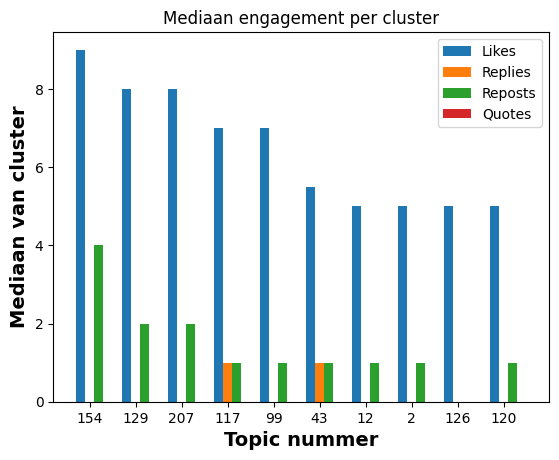

In [285]:
x_1 = grouped_top_2['Topic']
y_1 = grouped_top_2['likes']
y_2 = grouped_top_2['replies']
y_3 = grouped_top_2['reposts']
y_4 = grouped_top_2['quotes']

bar_width = 0.20
x = np.arange(len(grouped_top))

plt.bar(x - bar_width, y_1, width=bar_width, label='Likes')
plt.bar(x, y_2, width=bar_width, label='Replies')
plt.bar(x + bar_width, y_3, width=bar_width, label='Reposts')
plt.bar(x + 2*bar_width, y_4,width = bar_width, label='Quotes')

plt.xlabel('Topic nummer', fontweight='bold',fontsize=14)
plt.ylabel('Mediaan van cluster', fontweight='bold',fontsize=14)
plt.xticks(x, x_1)
plt.legend()
plt.title("Mediaan engagement per cluster")
plt.show()

In [199]:
df_topics[df_topics['Topic'].isin([154,129,207,117,99,43,12,2,126,120])][['Topic','Count','Representation']]

Topic  Count  \
2    2      5352    
12   12     3276    
43   43     1240    
99   99     1400    
117  117    746     
120  120    515     
126  126    836     
129  129    700     
154  154    224     
207  207    238     

                                                                                             Representation  
2    [renee, good, ross, nicole, jonathan, agent, her, shot, murdered, killed]                               
12   [car, her, agent, vehicle, she, was, officer, shot, woman, video]                                       
43   [this, here, lol, you, my, me, it, post, what, lmao]                                                    
99   [agent, every, an, startribune, you, ice, he, wh, agents, his]                                          
117  [art, my, oc, some, artist, love, draw, ocs, fi, drawing]                                               
120  [bsky, social, emilyhearth, karenb4good, rosaliewong, poetry, credit, visibilitybrigade, poem, emmatk]  
126  [snow, winter, my, photography, morning, day, cold, today, weather, storm]                              
129  [renee, good, nicole, minneapolis, protest, vigil, protests, killed, killing, fatal]                    
154  [porter, keith, duty, eve, killed, off, jr, year, black, northridge]                                    
207  [students, school, high, walked, protest, walkout, kids, schools, out, walk]

In [353]:
temp = df_2[df_2['Topic'] == 207].sort_values(by='likes',ascending=False)
temp[temp["text"].str.contains('')]

uri  \
394095  at://did:plc:qrcrc4zkaavwzwdlpj35ufwm/app.bsky.feed.post/3lhf44k3cgs2a   
227018  at://did:plc:2iewc6lixswfqqsicmukhboe/app.bsky.feed.post/3mcijjfqojc25   
8282    at://did:plc:s4t4ce7wbksdau5aqb5aqa4u/app.bsky.feed.post/3ljb6bsjg422f   
392773  at://did:plc:3hd67og56zzdsqhqf2yqs2v7/app.bsky.feed.post/3m7lfcqiups22   
227519  at://did:plc:wlvvydeyjpiafdpnuzma4mzl/app.bsky.feed.post/3mbxmijwsps27   
...                                                                        ...   
431883  at://did:plc:zkqwmjng6bdsg6o5lk2plj2s/app.bsky.feed.post/3mcdg3itym224   
433458  at://did:plc:cuqqnhdesgprsc7cehirhss4/app.bsky.feed.post/3lhm4llrrkc2r   
440454  at://did:plc:xnb4sqtrr7y2cn7icdclrpp2/app.bsky.feed.post/3lk4fpcttks2d   
450407  at://did:plc:6sf4feeie6jrhmwyliqjt65k/app.bsky.feed.post/3mcl5wkmuq22x   
454415  at://did:plc:y7pbxy5us3egklcethupg3jw/app.bsky.feed.post/3ltnguvulss2o   

                                                                                                                                                                                                                                                                                          text  \
394095  STUDENT WALK OUT- OUTSIDE LOS ANGELES CITY HALL:\n\nHigh school students from all over LA have walked out of class and gathered in front of city hall to protest the president’s fascist agenda. SOLIDARITY WITH THE YOUTH! FUCK ICE!                                                    
227018  Hundreds of high schoolers in Northfield walked out of school and to our town square in support of our immigrant neighbors and against the ICE occupation of our state. I’m so unspeakably proud of them (especially of the head organizer who is one of the teens from my parish.) 🕯️   
8282    Happening now: in Chicago's Rogers Park neighborhood, students at Sullivan High School are walking out this afternoon in protest of ICE and Trump's deportation regime.                                                                                                                  
392773  Students walked out of school at Burnsville High School in Minnesota to protest Trump’s ICE gestapo terrorizing their community….the kids are alright 💪!\n\n"NO MORE ICE! NO MORE ICE!"                                                                                                  
227519  Wow! This is amazing and it warms my heart! Elementary school kids at Kenny Community school in MN marched to protest against ICE. Schools are closed due to the safety concerns for immigrant students. These kids are changing the world for the better.                               
...                                                                                                                                                                                                                                                            ...                               
431883  I was playing on my phone at my local Anti-ICE rally on Saturday. Plenty of olds there recognized it. We shared memories of wearing black armbands in high school.                                                                                                                       
433458  Happening Now:\nStudents at Wilson Middle School in SD county stage a walk-out to protest ICE and anti-immigration policies.\nPhoto posted with permission.                                                                                                                              
440454  that is coming home to roost now as schools make legitimate protest more and more difficult and ICE seizes and disappears and seeks to deport a pro-Palestinian activist.                                                                                                                
450407  A glimmer of compassion in the MAGA red town of Forest Lake MN, where Hegseth graduated high school. This restaurant has been closed since Monday when ICE came knocking. People have 

117 en 120 lijken op clusters met random posts over art en het @en van mensen. 126 is ijsfotografie. Rest van de clusters zijn wel on-topic

In [340]:
topic_model.get_representative_docs(99)

['ICE agent?', 'ICE agent 🤣🤣', 'The ICE Agent!']

In [359]:
df.sort_values(by='likes', ascending=False).head(50)

uri  \
281954  at://did:plc:qldrnsjewtpl7nkqpfrjaqmv/app.bsky.feed.post/3mc6dofrs4s2p   
33083   at://did:plc:ats4shmeia7i7ildqm3denmd/app.bsky.feed.post/3mbupais22c2s   
267536  at://did:plc:uo2fna47c4v6zcnklxfhcvjb/app.bsky.feed.post/3mc3cz7hbtc24   
144935  at://did:plc:uo2fna47c4v6zcnklxfhcvjb/app.bsky.feed.post/3mc3cz7hbtc24   
144931  at://did:plc:uo2fna47c4v6zcnklxfhcvjb/app.bsky.feed.post/3mc3cz7hbtc24   
282821  at://did:plc:iu4j537hox5huj4bwnwgub4z/app.bsky.feed.post/3mbuool3blc2k   
42221   at://did:plc:4llrhdclvdlmmynkwsmg5tdc/app.bsky.feed.post/3lp5fz7vrak2l   
42271   at://did:plc:4llrhdclvdlmmynkwsmg5tdc/app.bsky.feed.post/3lp5fz7vrak2l   
50306   at://did:plc:elbx234mn73t4vtxk6t62wrp/app.bsky.feed.post/3mbus2s6s6s2b   
47143   at://did:plc:s2jiq5q6f5uhl7ywqbxtsvmu/app.bsky.feed.post/3mc3b6soa222e   
47144   at://did:plc:s2jiq5q6f5uhl7ywqbxtsvmu/app.bsky.feed.post/3mc3b6soa222e   
50705   at://did:plc:x4g4laxkmsrczwvnvbbgsm7g/app.bsky.feed.post/3mbud7yhl6s26   
96499   at://did:plc:x4g4laxkmsrczwvnvbbgsm7g/app.bsky.feed.post/3mbud7yhl6s26   
214098  at://did:plc:tax3e7cjn3dzxpgfjslqq56y/app.bsky.feed.post/3mcfyhf2sw22x   
228606  at://did:plc:tax3e7cjn3dzxpgfjslqq56y/app.bsky.feed.post/3mcfyhf2sw22x   
221181  at://did:plc:tax3e7cjn3dzxpgfjslqq56y/app.bsky.feed.post/3mcfyhf2sw22x   
210047  at://did:plc:t6ubj2wlhc34awzcymh3qpur/app.bsky.feed.post/3lkjxbqyr5k2o   
184912  at://did:plc:26tsf647wqnoo7umh4ywwz7a/app.bsky.feed.post/3mc3e2jec4c2c   
36602   at://did:plc:26tsf647wqnoo7umh4ywwz7a/app.bsky.feed.post/3mc3e2jec4c2c   
213972  at://did:plc:4llrhdclvdlmmynkwsmg5tdc/app.bsky.feed.post/3mckit34v3o2q   
221064  at://did:plc:4llrhdclvdlmmynkwsmg5tdc/app.bsky.feed.post/3mckit34v3o2q   
228312  at://did:plc:4llrhdclvdlmmynkwsmg5tdc/app.bsky.feed.post/3mckit34v3o2q   
137204  at://did:plc:qxwx3yb4m3dmjbu5luyyi7zm/app.bsky.feed.post/3mc3tpgs2tc23   
282235  at://did:plc:qxwx3yb4m3dmjbu5luyyi7zm/app.bsky.feed.post/3mc3tpgs2tc23   
30800   at://did:plc:qxwx3yb4m3dmjbu5luyyi7zm/app.bsky.feed.post/3mc3tpgs2tc23   
190773  at://did:plc:tgw3d4hvw3x5ijrxax7lg26u/app.bsky.feed.post/3lmrykh5abc2d   
218078  at://did:plc:iu4j537hox5huj4bwnwgub4z/app.bsky.feed.post/3m2dimhib7d25   
224498  at://did:plc:iu4j537hox5huj4bwnwgub4z/app.bsky.feed.post/3m2dimhib7d25   
165548  at://did:plc:2whlowi5jjjqrdrrj4lxh2lx/app.bsky.feed.post/3mbwcnucmds26   
200453  at://did:plc:iu4j537hox5huj4bwnwgub4z/app.bsky.feed.post/3m7tehcaomo2z   
268029  at://did:plc:iu4j537hox5huj4bwnwgub4z/app.bsky.feed.post/3mbuksbgp522s   
145816  at://did:plc:iu4j537hox5huj4bwnwgub4z/app.bsky.feed.post/3mbuksbgp522s   
66429   at://did:plc:q3bbdtxch45wvfxrxpblphxn/app.bsky.feed.post/3mbzcscqmos2d   
44713   at://did:plc:it4vfrn3hgrb3hsvvwfltqqa/app.bsky.feed.post/3mcfj4h3cis2p   
220900  at://did:plc:uo2fna47c4v6zcnklxfhcvjb/app.bsky.feed.post/3lvsv2ctj322v   
226823  at://did:plc:uo2fna47c4v6zcnklxfhcvjb/app.bsky.feed.post/3lvsv2ctj322v   
94385   at://did:plc:iu4j537hox5huj4bwnwgub4z/app.bsky.feed.post/3mcdhkwrbel2k   
244246  at://did:plc:xgiwtxbtt6xc7low5vdz7dq4/app.bsky.feed.post/3ltplrjqt2s2l   
238567  at://did:plc:xgiwtxbtt6xc7low5vdz7dq4/app.bsky.feed.post/3ltplrjqt2s2l   
198194  at://did:plc:x4qyokjtdzgl7gmqhsw4ajqj/app.bsky.feed.post/3mcj2unckyc2w   
150668  at://did:plc:x4qyokjtdzgl7gmqhsw4ajqj/app.bsky.feed.post/3mcj2unckyc2w   
278551  at://did:plc:qxwx3yb4m3dmjbu5luyyi7zm/app.bsky.feed.post/3m3umwhzqdk2l   
278602  at://did:plc:qxwx3yb4m3dmjbu5luyyi7zm/app.bsky.feed.post/3m3umwhzqdk2l   
152217  at://did:plc:svawqo4jxobyyuqmixplvcux/app.bsky.feed.post/3mbzq343sjs2l   
275498  at://did:plc:svawqo4jxobyyuqmixplvcux/app.bsky.feed.post/3mbzq343sjs2l   
113403  at://did:plc:svawqo4jxobyyuqmixplvcux/app.bsky.feed.post/3mbzq343sjs2l   
48786   at://did:plc:e3cyxeqboiqsybc3u6wvzysz/app.bsky.feed.post/3mbwonbghh22j   
150515  at://did:plc:x4g4laxkmsrczwvnvbbgsm7g/app.bsky.feed.post/3mcipcaudo223   
281990  at://did:plc:a67zdrt4nl2tv2qojpngogbq/app.bsky.fe